<a href="https://colab.research.google.com/github/josooik/DeepLearning/blob/main/2021_11_01_face_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Face_Clasifier

In [22]:
! git clone https://github.com/josooik/Face-detection-for-DSM

fatal: destination path 'Face-detection-for-DSM' already exists and is not an empty directory.


In [23]:
! git clone https://github.com/prajnasb/observations.git

fatal: destination path 'observations' already exists and is not an empty directory.


In [24]:
from imutils import paths
import sys, os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import applications, utils, layers, models, optimizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


### 데이터

In [25]:
def load_datasets(dataDir):
    print("[INFO] Load Datasets...")
    imagePaths = list(paths.list_images(dataDir))

    data = []
    labels = []
    for imagePath in imagePaths:
    	# extract the class label from the filename
    	label = imagePath.split(os.path.sep)[-2]
        #print(label)
    
    	# load the input image (224x224) and preprocess it
    	image = load_img(imagePath, target_size=(224, 224))
    	image = img_to_array(image)
    	image = applications.mobilenet_v2.preprocess_input(image)
    	# update the data and labels lists, respectively
    	data.append(image)
    	labels.append(label)
    
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = utils.to_categorical(labels)
    
    data = np.array(data, dtype="float32")
    labels = np.array(labels)
    print('* data shape:',data.shape, labels.shape)
    
    
    # the data for training and the remaining 20% for testing
    (trainX, testX, trainY, testY) = train_test_split(data, labels,
                                     test_size=0.20, stratify=labels, random_state=42)
    print('* splited data shape:',trainX.shape, testX.shape, trainY.shape, testY.shape)

    return trainX, testX, trainY, testY


In [26]:
! ls observations

experiements  mask_classifier  README.md


In [27]:
dataDir = 'observations/experiements/data'
trainX, testX, trainY, testY = load_datasets(dataDir)

[INFO] Load Datasets...
* data shape: (1376, 224, 224, 3) (1376, 2)
* splited data shape: (1100, 224, 224, 3) (276, 224, 224, 3) (1100, 2) (276, 2)


In [28]:
def train_model( trainX, testX, trainY, testY,
                 EPOCHS=1, 
                 INIT_LR=1e-4, 
                 BS=32):

    print("[INFO] Build  Model ...")
    base_model = applications.MobileNetV2( weights="imagenet", 
                                           include_top=False,
    	                                   input_tensor=layers.Input(shape=(224, 224, 3)))
    
    y = base_model.output
    y = layers.AveragePooling2D(pool_size=(7, 7))(y)
    y = layers.Flatten(name="flatten")(y)
    y = layers.Dense(128, activation="relu")(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(2, activation="softmax")(y)
    
    model = models.Model(inputs=base_model.input, outputs=y)
    for layer in base_model.layers:
    	layer.trainable = False
    

    # compile our model
    print("[INFO] Compiling  Model ...")
    opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


    # construct the training image generator for data augmentation
    aug = ImageDataGenerator( rotation_range=20,
    	                      zoom_range=0.15,
    	                      width_shift_range=0.2,
    	                      height_shift_range=0.2,
    	                      shear_range=0.15,
    	                      horizontal_flip=True,
    	                      fill_mode="nearest")

    # train the head of the network
    print("[INFO] Training  Model ...")
    history = model.fit( aug.flow(trainX, trainY, batch_size=BS),
	               steps_per_epoch=len(trainX) // BS,
	               validation_data=(testX, testY),
	               validation_steps=len(testX) // BS,
	               epochs=EPOCHS)

    return history, model

In [29]:
history, model = train_model(trainX, testX, trainY, testY, EPOCHS=20)

[INFO] Build  Model ...
[INFO] Compiling  Model ...
[INFO] Training  Model ...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
34/34 [==============================] - 18s 443ms/step - loss: 0.4845 - accuracy: 0.8193 - val_loss: 0.2087 - val_accuracy: 0.9746
Epoch 2/20
34/34 [==============================] - 14s 416ms/step - loss: 0.1900 - accuracy: 0.9669 - val_loss: 0.0978 - val_accuracy: 0.9783
Epoch 3/20
34/34 [==============================] - 14s 396ms/step - loss: 0.1243 - accuracy: 0.9747 - val_loss: 0.0637 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 14s 399ms/step - loss: 0.0839 - accuracy: 0.9860 - val_loss: 0.0473 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 14s 405ms/step - loss: 0.0541 - accuracy: 0.9944 - val_loss: 0.0382 - val_accuracy: 0.9891
Epoch 6/20
34/34 [==============================] - 14s 398ms/step - loss: 0.0515 - accuracy: 0.9906 - val_loss: 0.0326 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 14s 404ms/step - loss: 0.0442 - accuracy: 0.9888 - val_loss: 0.0282 - val_accuracy: 0.9964

In [30]:
model.save("my_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [31]:
def plot_leraning_curve(H):
    N = len(H.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N),  H.history["loss"], label="train_loss", marker='o',)
    plt.plot(np.arange(0, N),  H.history["val_loss"], label="val_loss", marker='o')
    plt.plot(np.arange(0, N),  H.history["accuracy"], label="train_acc", marker='o')
    plt.plot(np.arange(0, N),  H.history["val_accuracy"], label="val_acc", marker='o')
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("lerning_curve")
    plt.show()

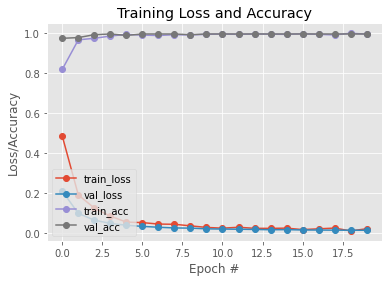

In [32]:
plot_leraning_curve((history))